In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix, fbeta_score,recall_score,precision_score

In [32]:
data = pd.read_csv("drive/MyDrive/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [33]:
print(data.shape)
data.columns

(284807, 31)


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [34]:
axis,occurence_classes = np.unique(data['Class'],return_counts=True)
totale = occurence_classes.sum()
print(f'pourcentage de la classe {axis[0]} : {occurence_classes[0]/totale}')
print(f'pourcentage de la classe {axis[1]} : {occurence_classes[1]/totale}')


pourcentage de la classe 0 : 0.9982725143693799
pourcentage de la classe 1 : 0.001727485630620034


On remarque que les classes ne sont pas balancées, donc l'accuracy pour évaluer notre modèle n'est pas adaptée

In [35]:
data_0,data_1 = data[data['Class'] == 0],data[data['Class'] == 1]

In [36]:
X_0,Y_0 = data_0.drop('Class',axis = 1),data_0['Class']
X_1,Y_1 = data_1.drop('Class',axis = 1),data_1['Class']


In [37]:
# Pour les classes authentiques
X_train, X_0_temp, Y_train, Y_0_temp = train_test_split(X_0, Y_0, test_size=0.2, random_state=40)
X_0_val, X_0_test, Y_0_val, Y_0_test = train_test_split(X_0_temp, Y_0_temp, test_size=0.5, random_state=40)

# Pour les classes frauduleuses
X_1_val, X_1_test, Y_1_val, Y_1_test = train_test_split(X_1, Y_1, test_size=0.5, random_state=40)

# Concaténation des caractéristiques et des étiquettes pour validation et test
X_val = pd.concat([X_0_val, X_1_val], axis=0)
Y_val = pd.concat([Y_0_val, Y_1_val], axis=0)
X_test = pd.concat([X_0_test, X_1_test], axis=0)
Y_test = pd.concat([Y_0_test, Y_1_test], axis=0)



In [38]:
labels = ['Train','Validation','Test']
y_0 = [len(Y_train[Y_train == 0]), len(Y_val[Y_val == 0]),len(Y_test[Y_test == 0])]
y_1 = [len(Y_train[Y_train == 1]), len(Y_val[Y_val == 1]),len(Y_test[Y_test == 1])]

fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(values = y_0, labels = labels, hole = 0.5, textinfo = 'percent', title = "Authentic"),
              row = 1, col = 1)
fig.add_trace(go.Pie(values = y_1, labels = labels, hole = 0.5, textinfo = 'percent', title = "Fraudulent"),
              row = 1, col = 2)
text_title = "Distribution of authentic and fraudulent transactions over training, validation and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

Pour choisir le nombre de bins de notre histogramme,on utilise la technique de Freedman-Diaconis

In [39]:
bins_train = math.floor(len(X_train)**(1/3))

#Feature engineering

In [40]:
# Decomposing time
for df in [X_train, X_val, X_test]:
    df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
    df['Hour'], temp = temp // (60*60), temp % (60*60)
    df['Minute'], df['Second'] = temp // 60, temp % 60
X_train[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()



,Time,Day,Hour,Minute,Second
19594,30401.0,0.0,8.0,26.0,41.0
124712,77397.0,0.0,21.0,29.0,57.0
167920,118964.0,1.0,9.0,2.0,44.0
47377,43191.0,0.0,11.0,59.0,51.0
41731,40804.0,0.0,11.0,20.0,4.0


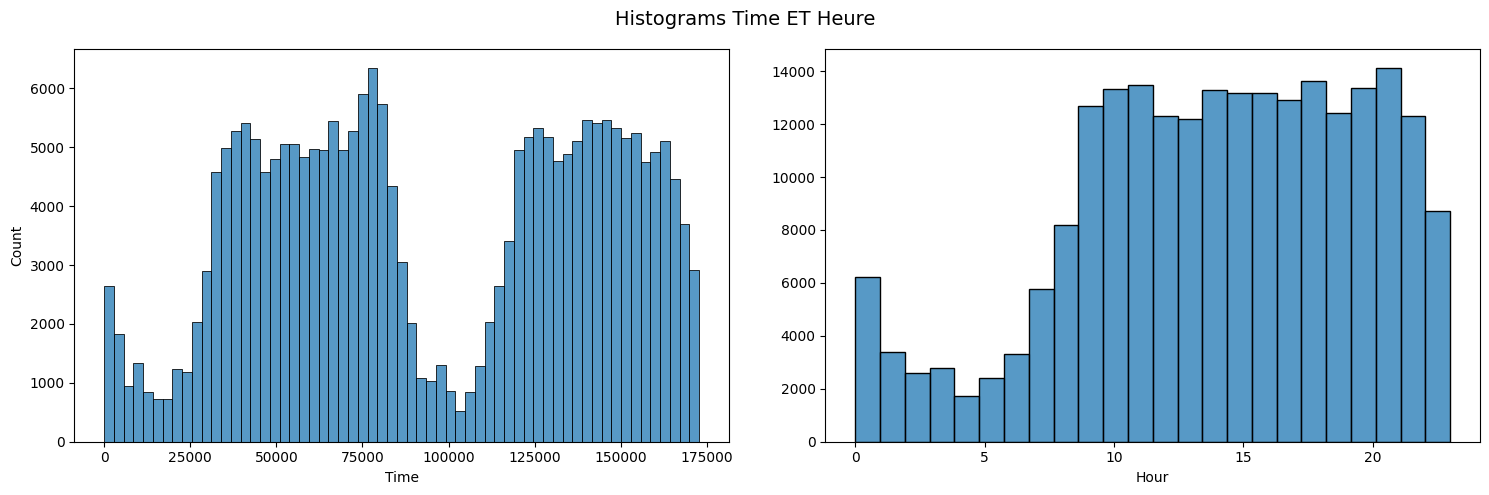

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.histplot(data = X_train, x = 'Time', bins = bins_train, ax = ax[0])
sns.histplot(data = X_train, x = 'Hour', bins = 24, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms Time ET Heure", size = 14)
plt.tight_layout()
plt.show()

In [42]:
# Transformation of 'Amount'
for df in [X_train, X_val, X_test]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)

In [43]:
for df in [X_train,X_val,X_test] :
  df.drop(['Time', 'Day', 'Minute', 'Second', 'Amount'],axis = 1,inplace = True)

#Feature selection

Le but c'est d'identifier les feature qui ont une distribution différente de la normale

In [67]:
#DIVISER LES DEUX CLASSE

X_val_0,X_val_1 = X_val[Y_val==0],X_val[Y_val==1]
print(X_val_1.shape)

(246, 30)


In [68]:

print(X_val_0.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Hour',
       'Amount_transformed'],
      dtype='object')


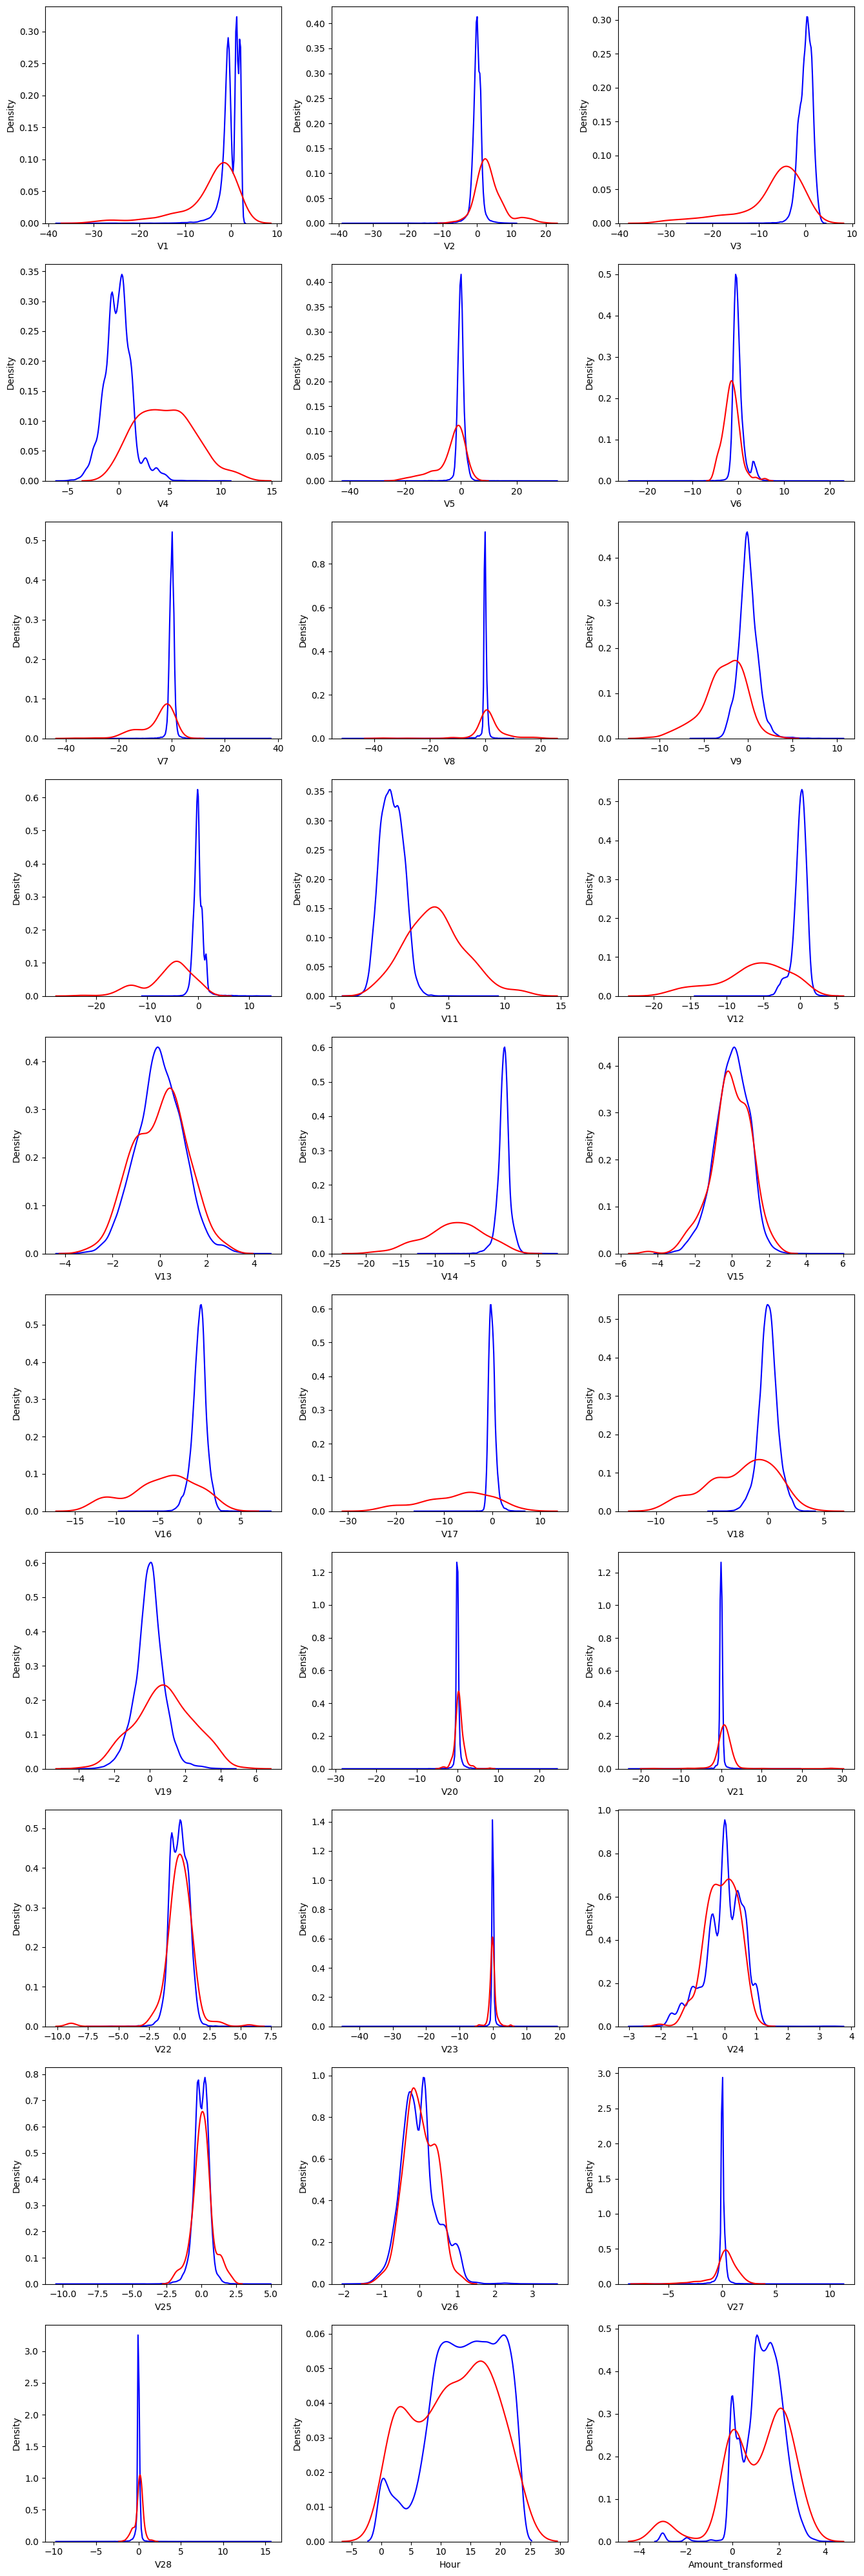

In [70]:
columns = X_val_0.columns
nb_col = 3
nb_lignes = math.ceil(len(columns) / nb_col)
fig, ax = plt.subplots(10, 3, figsize = (4.5 * 3, 4 * 10))
for i in range(len(X_val_0.columns)) :
  sns.kdeplot(X_val_0[columns[i]], ax = ax[i // nb_col,i % nb_col],color='blue',label = 'Classe authentique')
  sns.kdeplot(X_val_1[columns[i]], ax = ax[i // nb_col,i % nb_col],color = 'red',label = 'Classe frauduleuse')

plt.tight_layout()
plt.show()

In [72]:
feature_keep = ['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
X_train,X_val,X_test = X_train[feature_keep],X_val[feature_keep],X_test[feature_keep]

In [73]:
X_train.head()

,V4,V11,V12,V14,V16,V17,V18,V19,Hour
19594,-0.706232,2.027925,0.535822,0.250769,0.773615,0.449717,-1.963208,0.613481,8.0
124712,1.474933,-1.154523,0.263527,0.316174,-1.029415,1.030772,-0.438839,0.529080,21.0
167920,4.840766,-2.242431,0.034829,-0.546349,-0.070375,1.033695,0.531801,1.215045,9.0
47377,0.565273,-0.157045,-0.548790,0.419194,0.183518,-0.681323,0.911357,1.318132,11.0
41731,-0.428860,-0.580964,-0.609099,-0.187948,1.226723,0.104368,-0.995711,0.420557,11.0


In [149]:
def normal_density(x, mu, sigma):

    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f

In [150]:
def product_norml(x, vect_u, vect_sigm):
    result = 1
    for i in range(len(x)):
        result = result * normal_density(x[i], vect_u[i], vect_sigm[i])
    return result


In [151]:
vect_u,vect_sigm = X_train.mean(),X_train.std()


In [152]:
def model(batch_X, threshold) :
  y = []
  for i in batch_X.index:
      prob_density = product_norml(batch_X.loc[i].tolist(), vect_u, vect_sigm)
      y.append((prob_density < threshold).astype(int))
  return y

In [153]:
y_pred  = model(X_train,0.01)


Text(50.722222222222214, 0.5, 'Vrai')

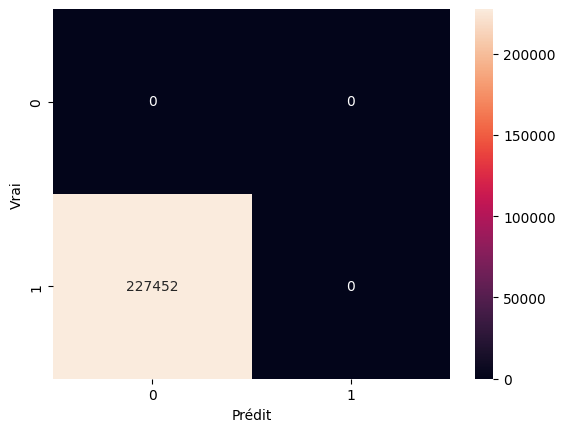

In [157]:
mc = confusion_matrix(y_pred,Y_train)
sns.heatmap(mc,annot=True, fmt='g')
plt.xlabel('Prédit')
plt.ylabel('Vrai')

On va mainenant sélectionner le meilleur threshold qui donner le meiller F2-Score sur les données de Validation

F2-score a été choisi car il donne plus d'importance sur le recal que sur la precision, et dans notre problématique, on préfére ne pas se tromper sur les fraude que de se tromper sur les vrai transactions

In [167]:
plage_threshold = np.arange(0.001, 0.051, 0.001)
liste_result = []
for threshold in plage_threshold :
  liste_result.append(fbeta_score(model(X_val,threshold **X_val.shape[1]),Y_val,beta = 2))

Text(0, 0.5, 'f2-score')

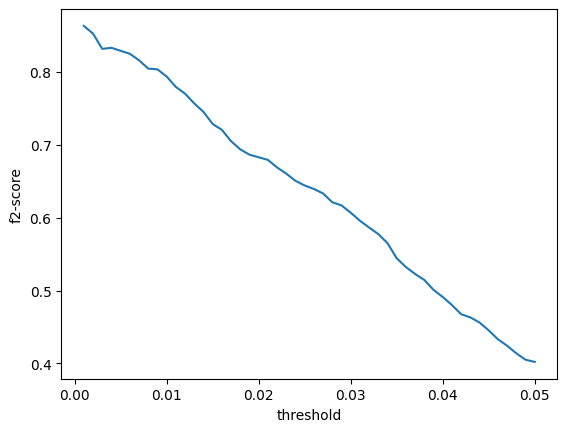

In [168]:
plt.plot(plage_threshold,liste_result)
plt.xlabel('threshold')
plt.ylabel('f2-score')

In [172]:
best_threshold = plage_threshold[np.argmax(liste_result)] ** X_val.shape[1]

1.0000000000000002e-27

Pour les données de Test maintenant

In [179]:
y_pred = model(X_test,best_threshold)


Text(50.722222222222214, 0.5, 'Vrai')

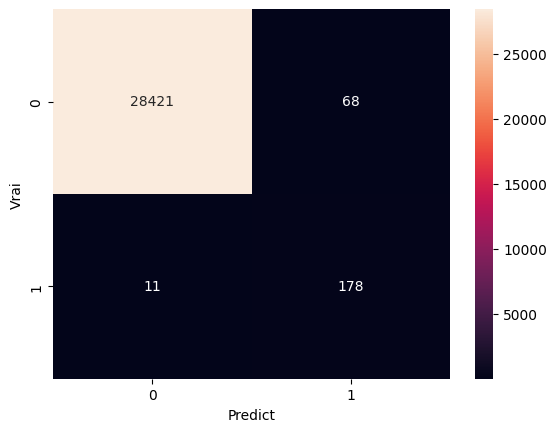

In [180]:
cm_test = confusion_matrix(y_pred,Y_test)
sns.heatmap(cm_test,annot = True,fmt='g')
plt.xlabel('Predict')
plt.ylabel('Vrai')

In [185]:
print(f'Le score F2 pour les données de test est de {fbeta_score(y_pred, Y_test,beta = 2)}')
print(f'Le Recall pour les données de test est de {recall_score(y_pred, Y_test)}')
print(f'La précision pour les données de test est de {precision_score(y_pred, Y_test)}')


Le score F2 pour les données de test est de 0.8882235528942116
Le Recall pour les données de test est de 0.9417989417989417
La précision pour les données de test est de 0.7235772357723578
